# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import nan
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time
from scipy import stats


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv(delimiter=';',filepath_or_buffer='Udacity_AZDIAS_Subset.csv')

# Load in the feature summary file.
feat_info = pd.read_csv(delimiter=';', filepath_or_buffer='AZDIAS_Feature_Summary.csv')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,KBA05_ANTG1,person,ordinal,[-1]
freq,1,43,49,26


In [7]:
feat_info.dtypes

attribute             object
information_level     object
type                  object
missing_or_unknown    object
dtype: object

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

Converting the string column to list column by apply split function to the second and last item in the string.

Understanding the structure of the missing column

In [8]:
feat_info.missing_or_unknown[0] #understanding the structure of the column and its string

'[-1,0]'

In [9]:
type(feat_info.missing_or_unknown[0])

str

In [10]:
feat_info.missing_or_unknown[0][1:-1]

'-1,0'

In [11]:
a = feat_info['missing_or_unknown'][0].strip('[')
a = feat_info['missing_or_unknown'][0].strip(']')
a =feat_info.missing_or_unknown[0][1:-1].split(',')
print (a)


['-1', '0']


In [12]:
'''for i in range(2):
    missing = feat_info.iloc[i]['missing_or_unknown'].strip('[')
    print (missing, type(missing))
    missing = missing.strip(']')
    print (missing, type(missing))

    missing = missing.split(sep = ',')
    print (missing, type(missing))
    missing = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing]
    print (missing, type(missing))
    if missing != ['']:
        x = azdias.replace({feat_info.iloc[i]['attribute']: [-1,0,9]}, np.nan)
        print (x)'''

"for i in range(2):\n    missing = feat_info.iloc[i]['missing_or_unknown'].strip('[')\n    print (missing, type(missing))\n    missing = missing.strip(']')\n    print (missing, type(missing))\n\n    missing = missing.split(sep = ',')\n    print (missing, type(missing))\n    missing = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing]\n    print (missing, type(missing))\n    if missing != ['']:\n        x = azdias.replace({feat_info.iloc[i]['attribute']: [-1,0,9]}, np.nan)\n        print (x)"

In [13]:
for i in range(len(feat_info)):
    missing = feat_info.iloc[i]['missing_or_unknown'].strip('[')
    missing = missing.strip(']')
    missing = missing.split(sep = ',')
    missing = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing]
    if missing != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing}, np.nan)
    

In [14]:
# Identify missing or unknown data values and convert them to NaNs.
#a=feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))


In [15]:
azdias['AGER_TYP'].head()

0    NaN
1    NaN
2    NaN
3    2.0
4    NaN
Name: AGER_TYP, dtype: float64

In [16]:
len(azdias)

891221

In [17]:
#below takes into account all the columns
len(azdias.isnull().sum())

85

In [18]:
azdias[azdias.isnull()].shape


(891221, 85)

In [19]:
azdias.shape

(891221, 85)

In [20]:
type(azdias.isnull().sum())

pandas.core.series.Series

In [21]:
isn = azdias.isnull().sum()
for i in isn.index:
    print (type(i))
    break

<class 'str'>


In [22]:
sorted(azdias.isnull().sum() ,reverse=True)[0:5]

[889061, 685843, 584612, 476524, 392318]

<Container object of 85 artists>

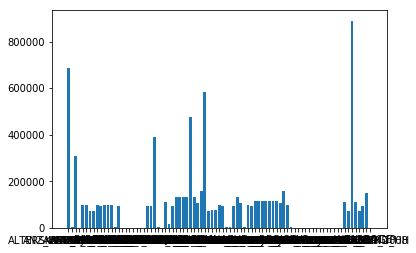

In [23]:
plt.bar(x=azdias.columns, height =azdias.isnull().sum(), )

In [24]:
#counts non-NA values for each column
sorted(azdias.count(), reverse=False)[:5]

[2160, 205378, 306609, 414697, 498903]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

There are 30 column s with almost none missing values.
And there are few with with more than 20% missing.

Text(0.5,1,'Ratio of missing values')

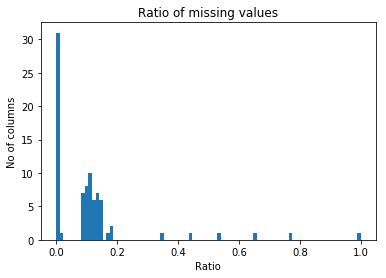

In [25]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.hist(azdias.isnull().sum()/len(azdias), bins=len(azdias.columns))

plt.xlabel('Ratio')
plt.ylabel('No of columns')
plt.title('Ratio of missing values')


In [26]:
# Investigate patterns in the amount of missing data in each column.
#miss_data = azdias.shape
azdias.AGER_TYP.isnull().sum()/len(azdias.AGER_TYP)

0.76955435296071339

In [27]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
#taking out the outliers, i.e. those which are null data is more than 20%
#i.e. keeping columns with less than 20% missing data
miss_data = azdias.isnull().sum()/len(azdias)
miss_data_no_outlier = miss_data[miss_data<0.2]
miss_data_no_outlier.shape
#there are 79 columns left


(79,)

#### Columns with minimum missing data selected

In [28]:
miss_data_no_outlier.head()

ALTERSKATEGORIE_GROB    0.003233
ANREDE_KZ               0.000000
CJT_GESAMTTYP           0.005446
FINANZ_MINIMALIST       0.000000
FINANZ_SPARER           0.000000
dtype: float64

In [29]:
miss_data_no_outlier.index[:5]

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER'],
      dtype='object')

In [30]:
#sorting data based on ratio of missing data, descending
miss_data.sort_values(ascending = False).head().index

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR'], dtype='object')

#### Discussion 1.1.2: Assess Missing Data in Each Column

From above, we can see that the majority of columns have some missing data, where 30 columns have no missing data, and few columns, i.e. namely six of them had more than 20% missing data. The rest, 49 columns have up to 20% missing data

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [31]:
# How much data is missing in each row of the dataset?
# Below calculates the number of nulls in each row

miss_row=azdias.isnull().sum(axis=1)
miss_row.head()

0    49
1     4
2     4
3     9
4     3
dtype: int64

In [32]:
miss_row.describe()
#clearly it's not Haussian distribution. Data is skewed right

count    891221.000000
mean          9.396018
std          13.971829
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          54.000000
dtype: float64

In [33]:
azdias['miss_row']=miss_row
azdias['miss_row'].head()

0    49
1     4
2     4
3     9
4     3
Name: miss_row, dtype: int64

### Top rows with missing values

In [34]:
azdias.sort_values(by=['miss_row'], ascending = False).head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,miss_row
732775,NaN,3.0,2,NaN,3,5,3,5,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54
582372,NaN,3.0,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
33158,NaN,1.0,1,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
167341,NaN,2.0,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
56204,NaN,1.0,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53


In [35]:
#row with the max missing values - reconciles with above view
azdias['miss_row'][azdias['miss_row']==54]

732775    54
Name: miss_row, dtype: int64

#### Countplot of distribution of columns according to the number of missing values in the row.
There are around 50,000 rows with 53 missing values for example
Majority of rows have up to 7 missing column data. 
The absolute Majority of the missing data is within 13 columns or less. 

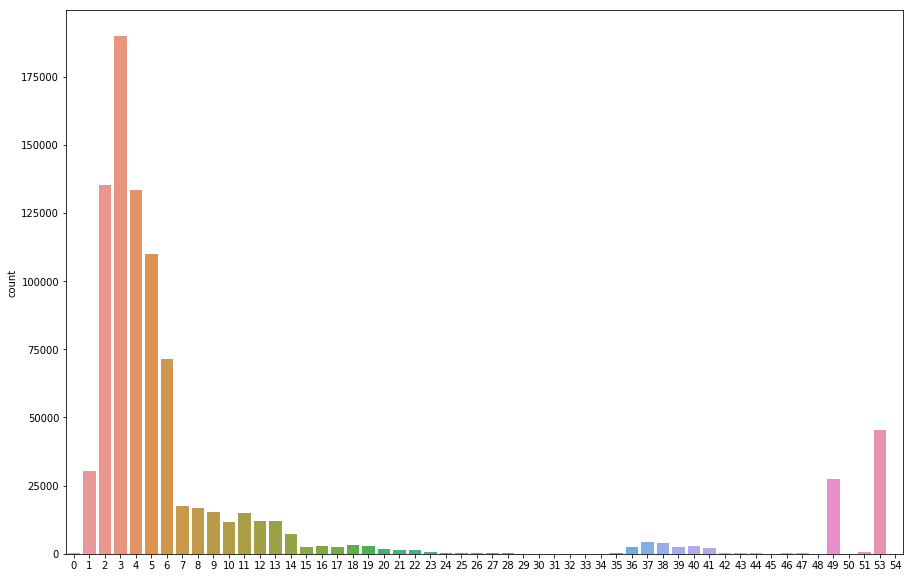

In [36]:

plt.figure(figsize=(15,10))
sns.countplot(x=miss_row)

Text(0.5,0.98,'Count plot for below and above 13 missing data points')

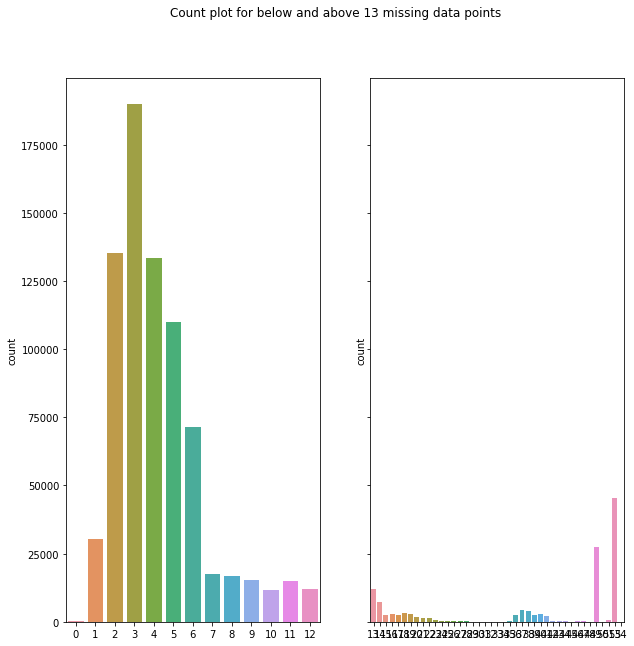

In [37]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# I will make a separation on 13 - number of missing values in the row, as it seems the line where the major difference is
fig, axs = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
sns.countplot(x=miss_row[miss_row<13], ax=axs[0])
sns.countplot(x=miss_row[miss_row>=13], ax=axs[1])
fig.suptitle('Count plot for below and above 13 missing data points')



Text(0.5,0.98,'Count plot for below 4 missing and above 35 missing data points')

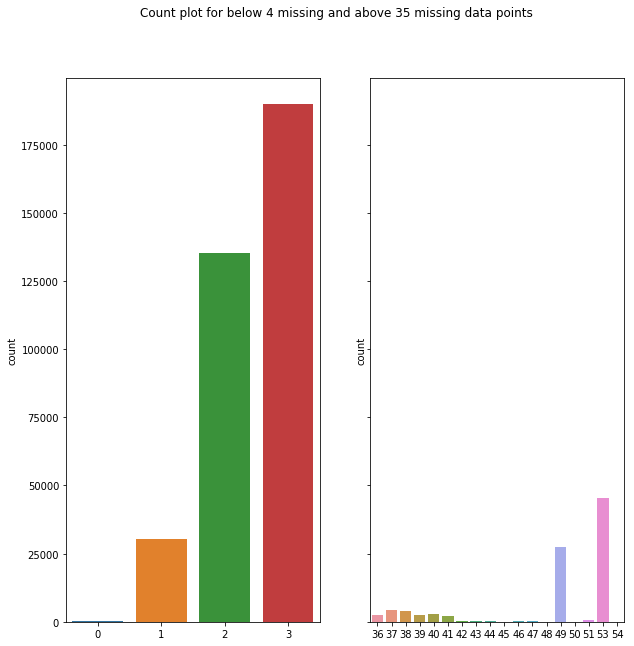

In [38]:
# comparing number of rows under different separation point, less thabn 4 values of missing data and more than 35
fig, axs = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
sns.countplot(x=miss_row[miss_row<4], ax=axs[0])
#sns.countplot(x=miss_row[(miss_row>=4)&(miss_row<7)], ax=axs[1])
sns.countplot(x=miss_row[miss_row>35], ax=axs[1])

fig.suptitle('Count plot for below 4 missing and above 35 missing data points')

In [39]:
# slicing data to come up with correct rows and columns
# selecting rows where missing rows are at the minimum
top_5_miss_col = miss_data.sort_values(ascending = True).head().index
print(azdias[top_5_miss_col[0]].head())
miss_df = azdias[azdias['miss_row']<5]
#miss_df2=azdias[(azdias.miss_row>=5)&(azdias.miss_row<9)]
miss_df2 = azdias[azdias['miss_row']>35]
miss_df2[top_5_miss_col[0]].head()

0    3
1    5
2    5
3    3
4    4
Name: ZABEOTYP, dtype: int64


0     3
11    3
14    3
17    3
24    3
Name: ZABEOTYP, dtype: int64

### Plotting missing rows data for top 5 columns with least missing data
Columns with least missing values were plotted - where first plot included rows with at least missing data, i.e. less than 5 and the second plot included the rows with the most missing data, i.e. >35

Text(0.5,0.98,'Count plot for below 7 and above 35 missing data points')

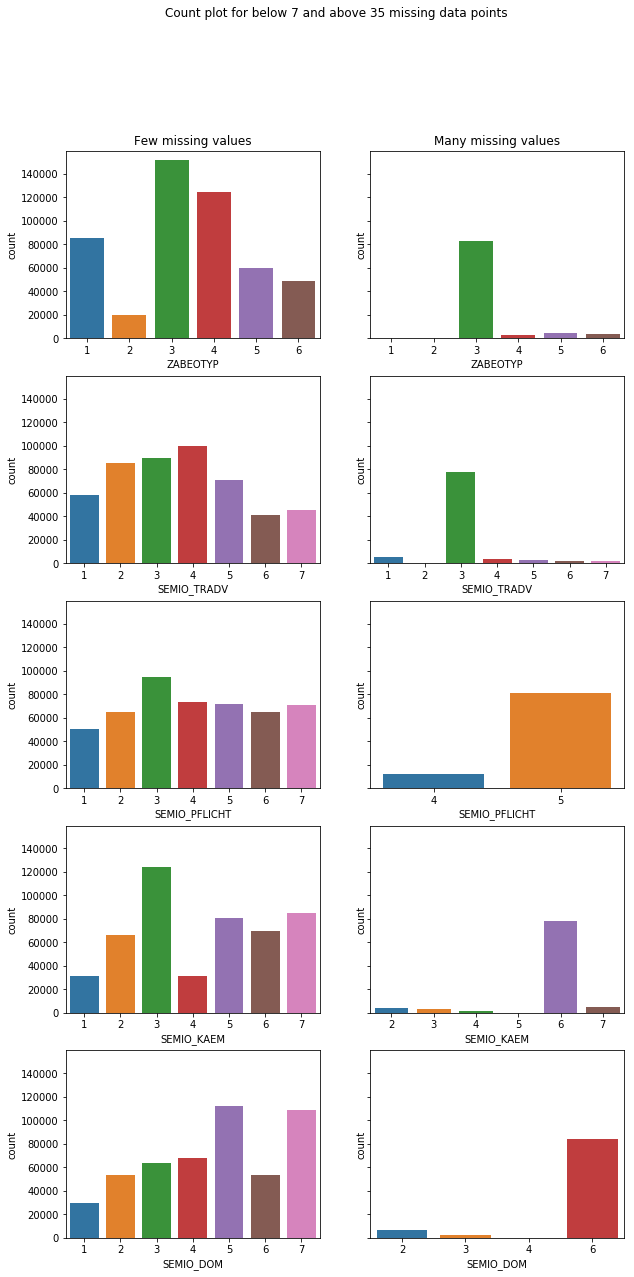

In [40]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

fig, axs = plt.subplots(5, 2, figsize=(10, 20),sharey=True, sharex = False)

sns.countplot(x=miss_df[top_5_miss_col[0]], ax=axs[0][0])
axs[0][0].set_title('Few missing values')
sns.countplot(x=miss_df2[top_5_miss_col[0]], ax=axs[0][1])
axs[0][1].set_title('Many missing values')
sns.countplot(x=miss_df[top_5_miss_col[1]], ax=axs[1][0])
sns.countplot(x=miss_df2[top_5_miss_col[1]], ax=axs[1][1])
sns.countplot(x=miss_df[top_5_miss_col[2]], ax=axs[2][0])
sns.countplot(x=miss_df2[top_5_miss_col[2]], ax=axs[2][1])
sns.countplot(x=miss_df[top_5_miss_col[3]], ax=axs[3][0])
sns.countplot(x=miss_df2[top_5_miss_col[3]], ax=axs[3][1])
sns.countplot(x=miss_df[top_5_miss_col[4]], ax=axs[4][0])
sns.countplot(x=miss_df2[top_5_miss_col[4]], ax=axs[4][1])

fig.suptitle('Count plot for below 7 and above 35 missing data points')

#### Discussion 1.1.3: Assess Missing Data in Each Row
The above plots illustrated rows with missing data points count of the columns which contain the least amount of missing data. They are similar with one another, where majority of the rows with missing data have 1 to 7 missing values. There were much less rows with missing data points of more than 35 values. 
We should get rid of the columns with the most missing data as well as the rows with the most missing data

### Getting rid of columns and rows with the unacceptable amounts of missing data
Both for columns and rows we will select the data where the missing values should be at least below 20%. 
For rows the max missing data points will be 85*20% = 17
However, I will select 11, to have a more rigorous subset.

In [41]:

azdias_new = azdias.loc[:,miss_data_no_outlier.index]
azdias_new.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [42]:
azdias_new.shape

(891221, 79)

In [43]:
azdias_new['miss_row']=miss_row
azdias_new.shape

(891221, 80)

In [44]:
azdias_new.miss_row[:5]

0    49
1     4
2     4
3     9
4     3
Name: miss_row, dtype: int64

In [45]:
azdias_new = azdias_new[azdias_new['miss_row']<12]

In [46]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,miss_row
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,4
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,4
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,9
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,3
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2


In [47]:
azdias_new.shape

(747117, 80)

### Dealing with missing values
Imputing the missing values using scikit-learn.
To use mean values for numeric columns and the most frequent value for non-numeric columns wew could do something like this. You could further distinguish between integers and floats. It might make sense to use the median for integer columns instead.
https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn

In [48]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


X = pd.DataFrame(azdias_new)
azdias_xt = DataFrameImputer().fit_transform(X)

In [49]:
azdias_xt.isnull().sum()


ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GFK_URLAUBERTYP          0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
LP_FAMILIE_FEIN          0
LP_FAMILIE_GROB          0
LP_STATUS_FEIN           0
LP_STATUS_GROB           0
NATIONALITAET_KZ         0
PRAEGENDE_JUGENDJAHRE    0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
                        ..
OST_WEST_KZ              0
WOHNLAGE                 0
CAMEO_DEUG_2015          0
CAMEO_DEU_2015           0
CAMEO_INTL_2015          0
KBA05_ANTG1              0
K

In [50]:
azdias_new=azdias_xt

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [51]:
feat_info['type'].nunique()

5

#### There are so many columns of each data type

In [52]:
feat_info.groupby('type')['attribute'].nunique()


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### However, the data frame is encoded as follows: 76 numeric and 4 categorical data

In [53]:
# How many features are there of each data type?
types = ['number', 'object', 'datetime','bool','void']
for i in types:
    print (i, "-",azdias_new.select_dtypes(include=[i]).shape[1])


number - 76
object - 4
datetime - 0
bool - 0
void - 0


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [54]:
categorical = feat_info['attribute'][feat_info['type']=='categorical']
print (categorical.head())
print (type(categorical))
print (categorical.iloc[:5])

0            AGER_TYP
2           ANREDE_KZ
3       CJT_GESAMTTYP
10          FINANZTYP
12    GFK_URLAUBERTYP
Name: attribute, dtype: object
<class 'pandas.core.series.Series'>
0            AGER_TYP
2           ANREDE_KZ
3       CJT_GESAMTTYP
10          FINANZTYP
12    GFK_URLAUBERTYP
Name: attribute, dtype: object


In [55]:
azdias_new.columns[:5]

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER'],
      dtype='object')

In [56]:
#selecting only those categorical features which were not filtered out in 
#above steps (missing data steps)
print (categorical.filter(items = azdias_new.columns).head())
categorical = categorical.loc[categorical.isin(azdias_new.columns)]
categorical.head(5)

Series([], Name: attribute, dtype: object)


2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
Name: attribute, dtype: object

In [57]:
type(categorical)
len(categorical)
categorical.shape
categorical.index

Int64Index([2, 3, 10, 12, 13, 17, 18, 19, 20, 21, 38, 39, 41, 42, 52, 55, 57,
            58],
           dtype='int64')

In [58]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
azdias_categorical = azdias_new.loc[:,categorical]
azdias_categorical.head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5.0,1,10.0,0,5.000000,3.000000,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.000000,1.000000,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
3,2,2.0,6,1.0,0,3.959933,2.398154,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2,2A
4,1,5.0,5,5.0,0,10.000000,5.000000,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B
5,2,2.0,2,1.0,0,1.000000,1.000000,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8,8C


In [59]:
azdias_categorical.describe()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP
count,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000,747117.000000
mean,1.517452,3.471006,3.876867,7.459893,0.225029,3.959933,2.398154,4.771154,2.459172,1.167794,1.568445,0.008411,1.525010,3.388532,2.821495
std,0.499696,1.532025,2.077867,3.552317,0.417602,3.896338,1.679576,3.531974,1.514134,0.467823,1.012190,0.091325,0.492985,1.412893,2.673605
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,2.000000,4.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,1.000000
50%,2.000000,4.000000,5.000000,8.000000,0.000000,1.000000,1.000000,4.000000,2.000000,1.000000,1.568445,0.000000,2.000000,3.000000,1.000000
75%,2.000000,5.000000,6.000000,11.000000,0.000000,8.000000,4.000000,9.000000,4.000000,1.000000,2.000000,0.000000,2.000000,4.000000,3.000000
max,2.000000,6.000000,6.000000,12.000000,1.000000,11.000000,5.000000,10.000000,5.000000,3.000000,3.000000,1.000000,2.000000,6.000000,8.000000


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f42fab92898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f42fa7bc278>]], dtype=object)

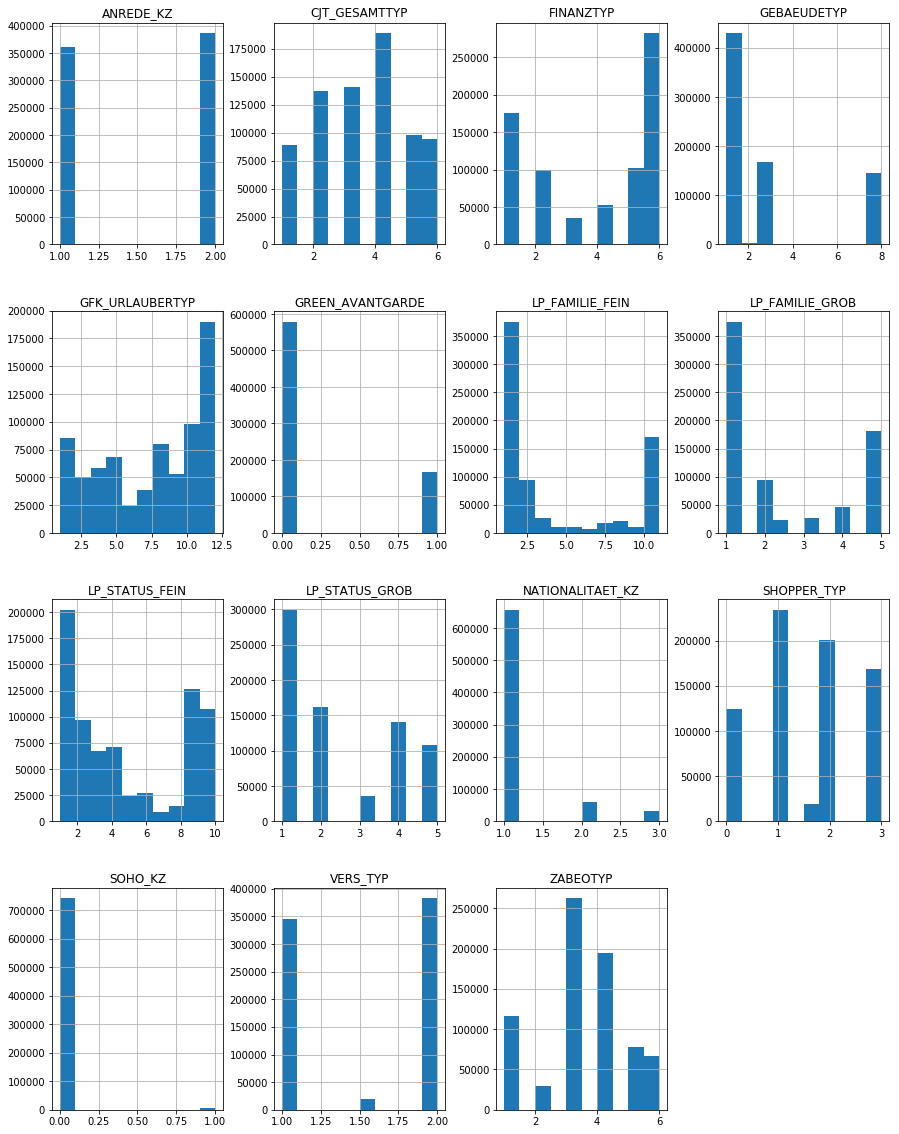

In [60]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
azdias_categorical[categorical].hist(ax = ax)

In [61]:
col_bi = []
col_m = []
for column in categorical:
    if azdias_new[column].nunique() > 2:
        col_m.append(column)
    else:
        col_bi.append(column)

In [62]:
#checking out the columns with binary data
for c in col_bi:
    print(azdias_new[c].value_counts())

2    386597
1    360520
Name: ANREDE_KZ, dtype: int64
0    578994
1    168123
Name: GREEN_AVANTGARDE, dtype: int64
0.0    740833
1.0      6284
Name: SOHO_KZ, dtype: int64
W    587007
O    160110
Name: OST_WEST_KZ, dtype: int64


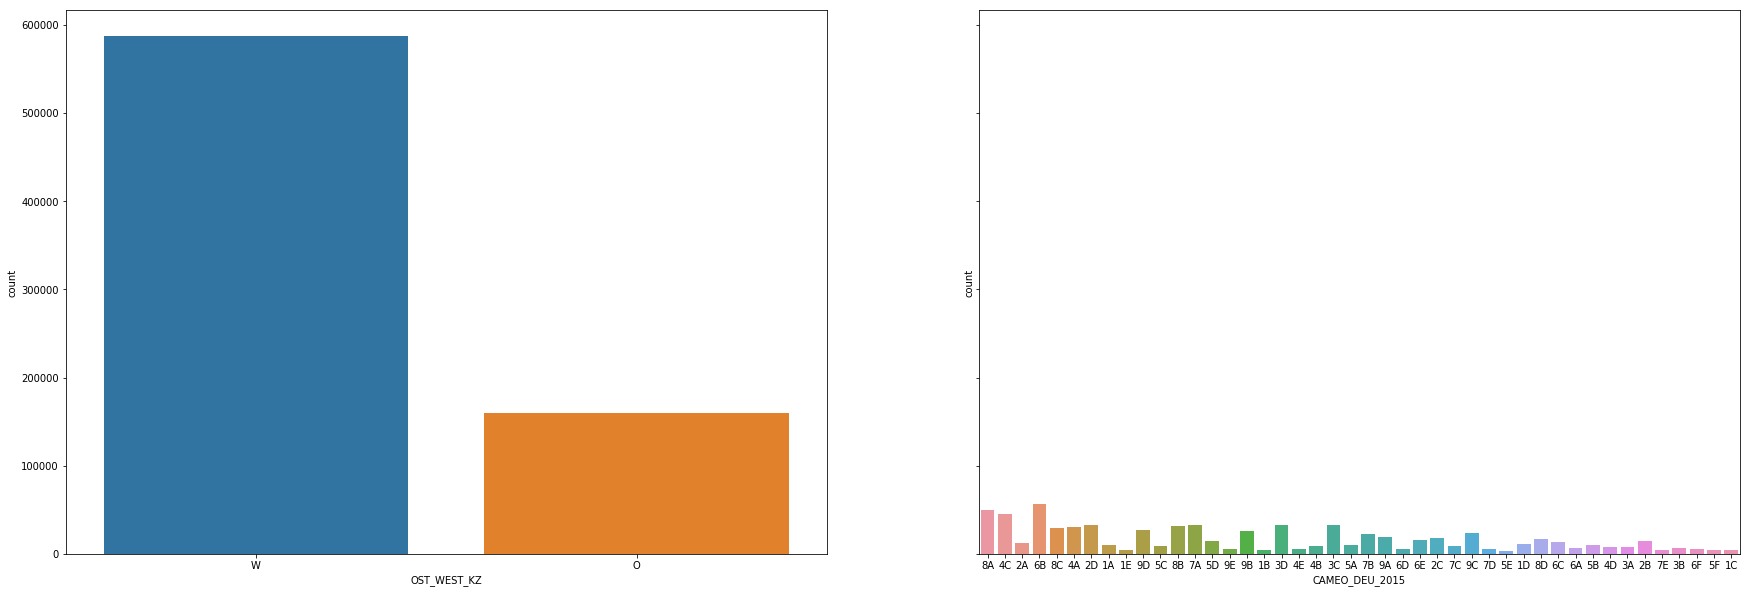

In [63]:
# countplots for column with string data
fig, axs = plt.subplots(1, 2, figsize=(30, 10),sharey=True, sharex = False)

sns.countplot(azdias_categorical['OST_WEST_KZ'], ax=axs[0])
sns.countplot(azdias_categorical['CAMEO_DEU_2015'], ax=axs[1])






In [64]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,miss_row
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,4
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,4
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,9
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,3
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2


In [65]:
# Re-encode categorical variable(s) to be kept in the analysis.

#azdias_new.OST_WEST_KZ = azdias_new.OST_WEST_KZ.replace ({'O': 0.0,'W': 1.0})  
azdias_new['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias_new['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
azdias_new['GREEN_AVANTGARDE'].replace([2,1], [1,0], inplace=True)






In [66]:
for c in col_bi:
    print(azdias_new[c].value_counts())

1    386597
0    360520
Name: ANREDE_KZ, dtype: int64
0    747117
Name: GREEN_AVANTGARDE, dtype: int64
0.0    740833
1.0      6284
Name: SOHO_KZ, dtype: int64
W    587007
O    160110
Name: OST_WEST_KZ, dtype: int64


I am going to drop azdias_categorical['CAMEO_DEU_2015'], GREEN_ADVANTGARDE as it doesn't seem to add much information and we already have numerous features

In [67]:
azdias_new.drop(['CAMEO_DEU_2015', 'GREEN_AVANTGARDE'], axis =1, inplace=True)

In [68]:
azdias_new.shape

(747117, 78)

#### I will drop all the multi categorical features to simplify the model

In [70]:
azdias_new.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015' ], axis =1, inplace=True)


In [72]:
azdias_new.shape

(747117, 60)

#### Discussion 1.2.1: Re-Encode Categorical Features

The binary and multi categorical features were identified and then binary features were encoded with either 1 or 0. For multi categorical features, the get_dummies method had been used

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [69]:
azdias_categorical.columns

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object')

In [73]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_new[['PRAEGENDE_JUGENDJAHRE']].head()



,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0


In [74]:
azdias_new[['PRAEGENDE_JUGENDJAHRE']].describe()


,PRAEGENDE_JUGENDJAHRE
count,747117.000000
mean,9.247281
std,4.005832
min,1.000000
25%,6.000000
50%,9.000000
75%,14.000000
max,15.000000


In [75]:
decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [76]:
azdias_new['DECADE'] = azdias_new['PRAEGENDE_JUGENDJAHRE'].replace(decade)
azdias_new['MOVEMENT']= azdias_new['PRAEGENDE_JUGENDJAHRE'].replace(movement)

In [77]:
azdias_new[['DECADE','MOVEMENT']].head()

,DECADE,MOVEMENT
1,6.0,1.0
2,6.0,0.0
3,4.0,1.0
4,4.0,1.0
5,2.0,1.0


In [78]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_new['CAMEO_INTL_2015'].head()


1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [79]:
azdias_new['CAMEO_INTL_2015'].describe()


count     747117
unique        21
top           51
freq      129719
Name: CAMEO_INTL_2015, dtype: object

In [80]:
wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [81]:
azdias_new['WEALTH']=azdias_new['CAMEO_INTL_2015'].replace(wealth)
azdias_new['LIFE_STAGE']=azdias_new['CAMEO_INTL_2015'].replace(life_stage)


In [82]:
azdias_new[['WEALTH','LIFE_STAGE']].head()

,WEALTH,LIFE_STAGE
1,5,1
2,2,4
3,1,2
4,4,3
5,5,4


In [83]:
azdias_new.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
azdias_new.shape

(747117, 64)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For mixed type feature columns the new features were created by mapping to the dictionaries. As the new features are ordinal they may be kept as such. The old columns with mixed features were dropped.
For example: Wealth was coded as  Wealthy Households: 1 Prosperous Households: 2 Comfortable Households: 3 Less Affluent Households: 4 Poorer Households: 5

Life stage was coded as: Pre-Family: 0 Young Couples: 1 Families: 2 Older Families: 3 Elders: 4

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [84]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

np.unique(azdias_new.dtypes.values)


array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [85]:
azdias_new.dtypes.value_counts() #before I cleaned the data it had object in it

float64    40
int64      23
object      1
dtype: int64

Selecting the column which is the object

In [86]:
azdias_new.select_dtypes(include ='object').head() 

,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54


In [87]:
azdias_new['CAMEO_INTL_2015']=azdias_new['CAMEO_INTL_2015'].apply(pd.to_numeric)

In [88]:
# Now no data with object type
azdias_new.dtypes.value_counts()

float64    40
int64      24
dtype: int64

In [90]:
#Now looking for columns where there are outlier data, i.e. data which is say beyond 3 standard deviations

#https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
#azdias_new[(np.abs(stats.zscore(azdias_new))>3).all(axis=0)]
#azdias_new[np.abs(azdias_new-azdias_new.mean()) >= (3*azdias_new.std())]

outl =azdias_new[(azdias_new - azdias_new.mean())/(3*azdias_new.std())>1]


In [97]:
#cols = list(outl.columns)
#outl[outl.notnull().value_counts()]
outl.nunique().sort_values(ascending = False).head(10)


ANZ_HAUSHALTE_AKTIV    237
ANZ_HH_TITEL            20
MIN_GEBAEUDEJAHR        11
KBA13_ANZAHL_PKW         7
MOVEMENT                 1
DECADE                   1
SEMIO_TRADV              0
SEMIO_PFLICHT            0
SEMIO_KAEM               0
SEMIO_DOM                0
dtype: int64

In [ ]:
# also dropping columns with outlier features which distort clustering. Also dropping the missing_row column which we added ourselves
azdias_new.drop(['SOHO_KZ','ANZ_PERSONEN','ANZ_TITEL', 'miss_row'], axis =1, inplace=True )

In [99]:

# also dropping columns with outlier features which distort clustering
azdias_new.drop(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL','MIN_GEBAEUDEJAHR','KBA13_ANZAHL_PKW'], axis =1, inplace=True )

In [100]:
azdias_new.shape

(747117, 58)

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functionds.




### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [134]:
#DELETE THIS ONLY IF THE BELOW COPY OF THIS CELL IS STILL AVAILABLE!!
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range(len(feat_info)):
        missing = feat_info.iloc[i]['missing_or_unknown'].strip('[')
        missing = missing.strip(']')
        missing = missing.split(sep = ',')
        missing = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing]
        if missing != ['']:
            df = df.replace({feat_info.iloc[i]['attribute']: missing}, np.nan)
    # missing data 
    #missing columns
    miss_data_no_outlier = miss_data[(azdias.isnull().sum()/len(azdias))<0.2]
    #missing rows
    miss_row=df.isnull().sum(axis=1)
    df['miss_row'] = miss_row

    df = df.drop(to_drop, axis = 1)
    
    # remove selected columns and rows, ...
    df_new = df.loc[:,miss_data_no_outlier.index]
    df_new = df_new[df_new['miss_row']<12]
    
    #replacing NaN values with most frequent, mean or median:
    from sklearn.base import TransformerMixin

    

    X = pd.DataFrame(df_new)
    df_new = DataFrameImputer().fit_transform(X)
    
    # select, re-encode, and engineer column values.
    df_new['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df_new['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    df_new['GREEN_AVANTGARDE'].replace([2,1], [1,0], inplace=True)
    
    # drop unnecessary columns:
    df_new.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015','SOHO_KZ','ANZ_PERSONEN','ANZ_TITEL', 'miss_row', 
                 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL','MIN_GEBAEUDEJAHR','KBA13_ANZAHL_PKW'], axis =1, inplace=True)
    #re-engineer the mixed value columns:
    df_new['DECADE'] = azdias_new['PRAEGENDE_JUGENDJAHRE'].replace(decade)
    df_new['MOVEMENT']= azdias_new['PRAEGENDE_JUGENDJAHRE'].replace(movement)
    
    df_new['WEALTH']=azdias_new['CAMEO_INTL_2015'].replace(wealth)
    df_new['LIFE_STAGE']=azdias_new['CAMEO_INTL_2015'].replace(life_stage)
    
    # Return the cleaned dataframe.
    return df_new, miss_data_no_outlier, miss_row
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [101]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# I have already imputed the values using the DataFrameImputer() method
azdias_new.head()



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,WEALTH,LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,3.0,21.000000,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,5,1
2,3.0,1,1,4,1,2,3,5,3.0,3.000000,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,2,4
3,4.0,1,4,2,5,2,1,2,2.0,16.304192,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,2
4,3.0,0,4,3,4,1,3,2,3.0,32.000000,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4,3
5,1.0,1,3,1,5,2,2,5,3.0,8.000000,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,5,4


In [103]:
# Apply feature scaling to the general population demographics data.
features = azdias_new.copy()

scaler = StandardScaler() 
azdias_new_scaled = scaler.fit_transform(azdias_new)

In [104]:
azdias_new_scaled = pd.DataFrame(azdias_new_scaled, columns=list(azdias_new))


In [105]:
azdias_new_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,WEALTH,LIFE_STAGE
count,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,...,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05,7.471170e+05
mean,-2.028325e-15,4.400728e-17,8.278381e-17,5.429522e-17,-7.054860e-17,-7.678271e-17,1.205784e-16,4.064771e-17,-1.022394e-15,3.369842e-16,...,1.555531e-16,2.922565e-16,4.376144e-16,1.821433e-15,-1.077041e-15,-2.262919e-15,1.108207e-15,-8.854715e-17,1.197652e-16,6.337296e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.747482e+00,-1.035534e+00,-1.523419e+00,-1.134998e+00,-1.773030e+00,-1.233108e+00,-1.151124e+00,-1.534058e+00,-1.617810e+00,-1.269692e+00,...,-1.621010e+00,-9.632189e-01,-6.485545e-01,-2.690525e+00,-2.144534e+00,-2.187612e+00,-1.874151e+00,-1.532943e+00,-1.551983e+00,-1.255627e+00
25%,-7.735686e-01,-1.035534e+00,-7.909943e-01,-1.134998e+00,-1.050929e+00,-1.233108e+00,-1.151124e+00,-8.145972e-01,-2.766330e-01,-8.548738e-01,...,-6.056077e-01,-9.632189e-01,-6.485545e-01,-6.294928e-01,-3.412258e-01,-1.772149e-01,-5.677517e-01,-7.951244e-01,-8.707139e-01,-1.255627e+00
50%,2.003445e-01,9.656849e-01,-5.856915e-02,-4.565593e-01,3.932715e-01,1.375263e-01,-4.277265e-01,-9.513601e-02,-2.766330e-01,-2.741279e-01,...,4.097951e-01,4.146119e-01,-6.485545e-01,1.830564e-15,-3.412258e-01,-1.772149e-01,-1.322853e-01,-5.730555e-02,4.918251e-01,8.644883e-02
75%,1.174258e+00,9.656849e-01,6.738560e-01,9.003175e-01,1.115372e+00,8.228433e-01,1.019069e+00,6.243252e-01,1.064544e+00,9.703274e-01,...,4.097951e-01,4.146119e-01,7.256828e-01,4.010234e-01,5.604281e-01,8.279839e-01,7.386474e-01,6.805132e-01,1.173095e+00,7.574867e-01
max,1.174258e+00,9.656849e-01,1.406281e+00,1.578756e+00,1.115372e+00,1.508160e+00,1.742467e+00,1.343786e+00,1.064544e+00,1.965892e+00,...,1.425198e+00,1.792443e+00,2.099920e+00,1.431540e+00,1.462082e+00,1.833183e+00,1.609580e+00,1.418332e+00,1.173095e+00,1.428524e+00


In [128]:
azdias_new_scaled.max().sort_values(ascending = False).head(10)

KBA05_ANTG4            2.694738
KONSUMNAEHE            2.574502
KBA05_ANTG3            2.369579
KBA05_ANTG2            2.227064
MOBI_REGIO             2.139065
PLZ8_BAUMAX            2.099920
WOHNLAGE               2.051498
LP_LEBENSPHASE_FEIN    1.965892
LP_LEBENSPHASE_GROB    1.906885
SEMIO_RAT              1.883809
dtype: float64

In [130]:
azdias_new_scaled.min().sort_values(ascending = True).head(10)

WOHNDAUER_2008          -3.672185
PLZ8_ANTG2              -3.051616
GEBAEUDETYP_RASTER      -2.979810
PLZ8_HHZ                -2.690525
PLZ8_ANTG1              -2.321055
HH_EINKOMMEN_SCORE      -2.226580
ARBEIT                  -2.187612
PLZ8_GBZ                -2.144534
WOHNLAGE                -2.118438
PRAEGENDE_JUGENDJAHRE   -2.058820
dtype: float64

In [113]:
# Checking if any outliers are still left even after scaling
azdias_new_scaled[(azdias_new - azdias_new.mean())/(3*azdias_new.std())>1].nunique().sort_values(ascending = False).head(10)


LIFE_STAGE       0
SEMIO_FAM        0
SEMIO_TRADV      0
SEMIO_PFLICHT    0
SEMIO_KAEM       0
SEMIO_DOM        0
SEMIO_KRIT       0
SEMIO_RAT        0
SEMIO_KULT       0
SEMIO_ERL        0
dtype: int64

### Discussion 2.1: Apply Feature Scaling

The nan values in the dataframe were replaced before this step, where the nan were replaced by the frequent value for categorical data and mean for numerical. 
Then the StandardScaler was used to create a dataframe with feature values with the mean of 0 and standard deviation of 1

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [114]:
# Apply PCA to the data.
pca = PCA()
pca_features = pca.fit_transform(azdias_new_scaled)


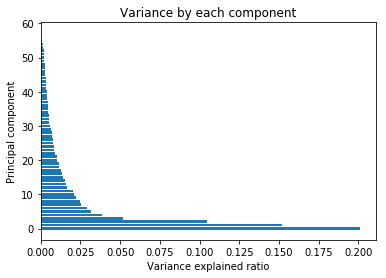

In [115]:
# Investigate the variance accounted for by each principal component.
plt.barh(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance by each component")
plt.ylabel("Principal component")
plt.xlabel("Variance explained ratio")
plt.show()



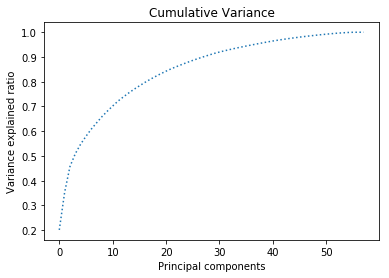

In [116]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), ':')
plt.title("Cumulative Variance")
plt.xlabel("Principal components")
plt.ylabel("Variance explained ratio")
plt.show()

In [117]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_35_comp = PCA(n_components=35)
azdias_pca = pca_35_comp.fit_transform(azdias_new_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

Cumulative explained variance of PCA showed that at the point around 35 features, the cumulative variance started having less variance explained ratio, i.e the curve was less steeper.
The 35 features were selected andn explain around 90% of the vraince. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [119]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_w(pca, dataframe, n):
    df = pd.DataFrame(pca.components_, columns=list(dataframe.columns))
    weights = df.iloc[n].sort_values(ascending=False)
    return weights


In [120]:
pca_w_0 = pca_w(pca_35_comp, azdias_new_scaled,0)

print (pca_w_0.head(), pca_w_0.tail())


PLZ8_ANTG3         0.229757
PLZ8_ANTG4         0.220937
PLZ8_BAUMAX        0.215146
WEALTH             0.207578
CAMEO_INTL_2015    0.204054
Name: 0, dtype: float64 FINANZ_MINIMALIST   -0.199975
KBA05_GBZ           -0.211251
KBA05_ANTG1         -0.219346
PLZ8_ANTG1          -0.227318
MOBI_REGIO          -0.236257
Name: 0, dtype: float64


In [121]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_w_1 = pca_w(pca_35_comp, azdias_new_scaled,1)
print (pca_w_1.head(), pca_w_1.tail())


SEMIO_REL                0.265661
PRAEGENDE_JUGENDJAHRE    0.260767
FINANZ_SPARER            0.249619
SEMIO_PFLICHT            0.238975
SEMIO_TRADV              0.237629
Name: 1, dtype: float64 RETOURTYP_BK_S         -0.167446
SEMIO_LUST             -0.189061
SEMIO_ERL              -0.236057
FINANZ_VORSORGER       -0.241204
ALTERSKATEGORIE_GROB   -0.268422
Name: 1, dtype: float64


In [122]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_w_2 = pca_w(pca_35_comp, azdias_new_scaled,2)
print (pca_w_2.head(), pca_w_2.tail())


SEMIO_VERT           0.349439
SEMIO_SOZ            0.261529
SEMIO_FAM            0.251519
SEMIO_KULT           0.234863
FINANZ_MINIMALIST    0.162903
Name: 2, dtype: float64 SEMIO_RAT    -0.219755
SEMIO_KRIT   -0.273772
SEMIO_DOM    -0.318450
SEMIO_KAEM   -0.342171
ANREDE_KZ    -0.371295
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components
Te first principal component positively correlates with PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX, WEALTH and several others. These features relate to indivdidual financial status and wealth.
The second principal component positively correlates with SEMIO_REL, PRAEGENDE_JUGENDJAHRE, FINANZ_SPARER, SEMIO_PFLICHT, SEMIO_TRADV and several others. These features related to age, decade of movements and savings.
The third principal componenet positively correlates with SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT, FINANZ_MINIMALIST and several others. These features relate to personality features, gender.
There is negative correlation as well, for example in the third principal component MOBI_REGIO and PLZ8_ANTG3. Basically with the share of 6-10 family homes decreases, it would result in lower movements.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [123]:
# code from Udacity cases
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score



In [124]:
#using samples
azdias_pca_sample = azdias_pca[np.random.choice(azdias_pca.shape[0], \
                                                    int(azdias_pca.shape[0]*0.2), replace=False)]

In [125]:
azdias_pca_sample.min()

-7.7746087688600953

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



run time    125.37920689582825


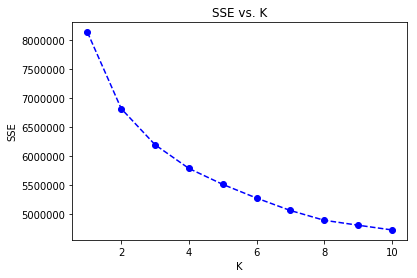

In [126]:
scores = []
centers = list(range(1,11))
start_time = time.time()
for center in centers:
    scores.append(get_kmeans_score(azdias_pca_sample, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
print ("run time   ", time.time()-start_time)

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [131]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
start_time = time.time()

kmeans = KMeans (n_clusters = 5) 

model = kmeans.fit(azdias_pca) #fitting to the data

kmeans_clusters = model.predict(azdias_pca)
print("Run time " % np.round(((time.time() - start_time)),2))


Run time 


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [132]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.